## FINAL SUBMIT

### Import 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

### Define CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), 
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),        # add dropout to reduce overfitting
            nn.Linear(256, 2)       # 2 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

### Load best model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=F

### Evaluate

For manual test

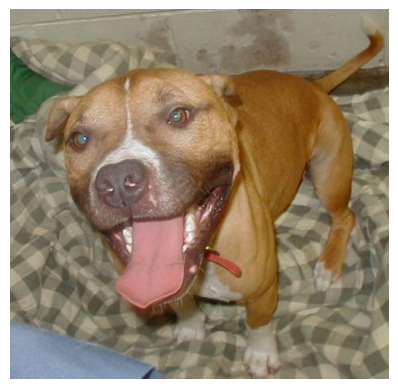

In [ ]:
# Load and show an image
from PIL import Image
import matplotlib.pyplot as plt

img_path = "PetImages_split/test/Dog/6.jpg" # Replace with your image path
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
#Predict image is a cat or dog
def predict_image(img_path, model, transform, classes, device):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
    return classes[predicted.item()]

#Predict
classes = ["Cat", "Dog"]  
val_test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
result = predict_image(img_path, model, val_test_transform, classes, device)
print("Result:", result)

Result: Dog


Automatic evaluate

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


val_test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


test_dataset = datasets.ImageFolder(root="YourPrivateTestSetPath/", transform=val_test_transform) #replace with your test set path


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


classes = test_dataset.classes  

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
print("Confusion Matrix:\n", cm)
for idx, cls in enumerate(classes):
    print(f"{cls} - Precision: {precision[idx]:.2f}, Recall: {recall[idx]:.2f}")

Confusion Matrix:
 [[1675  201]
 [ 197 1680]]
Cat - Precision: 0.89, Recall: 0.89
Dog - Precision: 0.89, Recall: 0.90
